In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import quantities as pq
from elephant.spike_train_generation import homogeneous_poisson_process
from elephant.statistics import instantaneous_rate
from elephant.statistics import isi
import plotly.graph_objects as go
from neo.core import SpikeTrain
from scipy import signal
from scipy.io import mmread
import seaborn as sns
import plotly.graph_objects as go

In [44]:
# %%
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("/users/nsr/saighi/data/sim_network/sim_stady_state_wii0.08_wie0.08_wei0.72_wext0.2") # Set this to your data path
prefix = "rf1"

In [14]:
#%%
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)


In [39]:
rateE  = np.mean([pd.read_csv("%s/%s.%i.e.prate"%(datadir,prefix,i),delimiter=' ').values for i in range(num_mpi_ranks)],axis=0)
time_axis = rateE[:,0]
rateE= rateE[:,1]
rateI  = np.mean([pd.read_csv("%s/%s.%i.i2.prate"%(datadir,prefix,i),delimiter=' ' ).values for i in range(num_mpi_ranks)],axis=0)
time_axis_I = rateI[:,0]
rateI= rateI[:,1]

wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

wmatfilesext  = ["%s/rf1.%i.ext.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
wext = np.sum( [ mmread(wf) for wf in wmatfilesext ] )

wmatfilesie  = ["%s/rf1.%i.ie.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
wie = np.sum( [ mmread(wf) for wf in wmatfilesie ] )


In [40]:
see  = np.concatenate([pd.read_csv("%s/%s.%i.see"%(datadir,prefix,i),delimiter=' ' ).values[:,1:-1] for i in range(3)],axis=1)
sie  = np.concatenate([pd.read_csv("%s/%s.%i.sie"%(datadir,prefix,i),delimiter=' ' ).values[:,1:-1] for i in range(3)],axis=1)
sse  = np.concatenate([pd.read_csv("%s/%s.%i.sse"%(datadir,prefix,i),delimiter=' ' ).values[:,1:-1] for i in range(3)],axis=1)

### Rate over time of inhibition and excitation

In [21]:
win = signal.windows.hann(100)
convoluted_rateE = np.convolve(rateE,win,'same')/ sum(win)

No handles with labels found to put in legend.


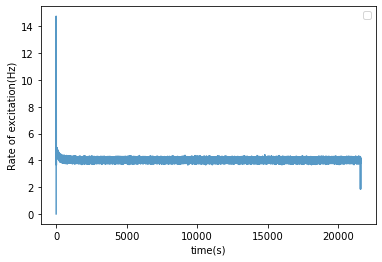

In [25]:
plt.plot(time_axis,convoluted_rateE,alpha = 0.75)
plt.xlabel("time(s)")
plt.ylabel("Rate of excitation(Hz)")
plt.legend()

In [26]:
convoluted_rateI = np.convolve(rateI,win,'same')/ sum(win)

Text(0, 0.5, 'Rate of inhibition(Hz)')

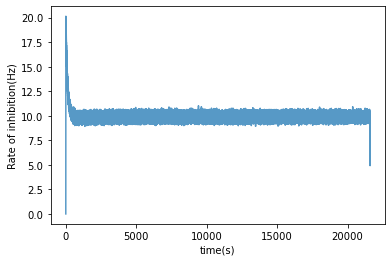

In [28]:

plt.plot(time_axis_I,convoluted_rateI,alpha = 0.75)
plt.xlabel("time(s)")
plt.ylabel("Rate of inhibition(Hz)")

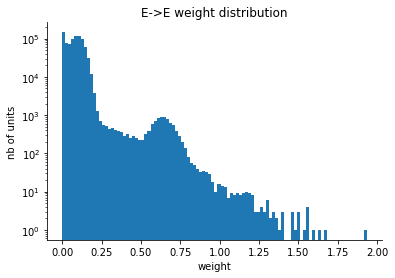

In [32]:
plt.hist(w.data, bins=100, log=True,label="Auryn")
plt.title("E->E weight distribution")
plt.xlabel("weight")
plt.ylabel("nb of units")
sns.despine()

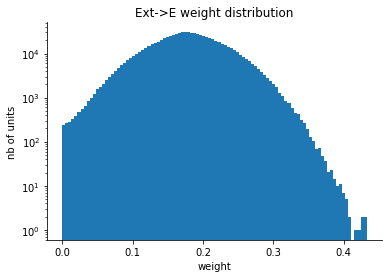

In [33]:
plt.hist(wext.data, bins=100, log=True,label="Auryn")
plt.title("Ext->E weight distribution")
plt.xlabel("weight")
plt.ylabel("nb of units")
sns.despine()

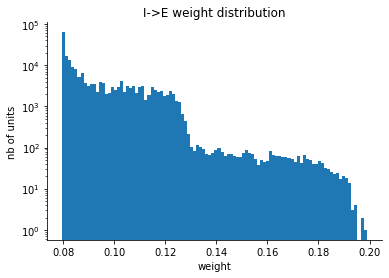

In [34]:
plt.hist(wie.data, bins=100, log=True,label="Auryn")
plt.title("I->E weight distribution")
plt.xlabel("weight")
plt.ylabel("nb of units")
sns.despine()

Text(0.5, 0, 'time(s)')

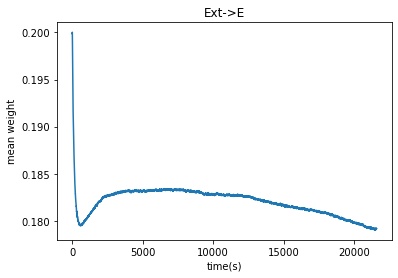

In [41]:
plt.plot(np.mean(sse,axis = 1))
plt.title("Ext->E")
plt.ylabel("mean weight")
plt.xlabel("time(s)")

Text(0.5, 0, 'time(s)')

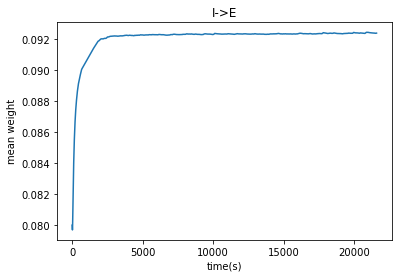

In [42]:
plt.plot(np.mean(sie,axis = 1))
plt.title("I->E")
plt.ylabel("mean weight")
plt.xlabel("time(s)")

Text(0.5, 0, 'time(s)')

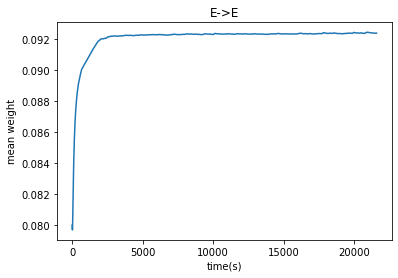

In [43]:
plt.plot(np.mean(sie,axis = 1))
plt.title("E->E")
plt.ylabel("mean weight")
plt.xlabel("time(s)")

### Weights distributions over time 

In [110]:
def distribution_in_time(synapses,label):
    fig, axes = plt.subplots(nrows=1, ncols=4,sharex=True,sharey=True,figsize=(15, 4))
    cpt = 0
    for t in range(int(synapses.shape[0]/4),synapses.shape[0],int(synapses.shape[0]/4)):
        values = synapses[t,1:-1][np.where(synapses[t,1:-1]!=0)[0]]
        axes[cpt].hist(values,bins=50,log=True)
        #plt.hist(weight_InputE["w"][:,t],alpha=0.7,bins=15)
        axes[cpt].set_title("Time: "+str(t)+"s")
        cpt+=1

    fig.text(0.5, -0.05, "weights "+label, ha='center')
    fig.tight_layout()
    #plt.show()
       

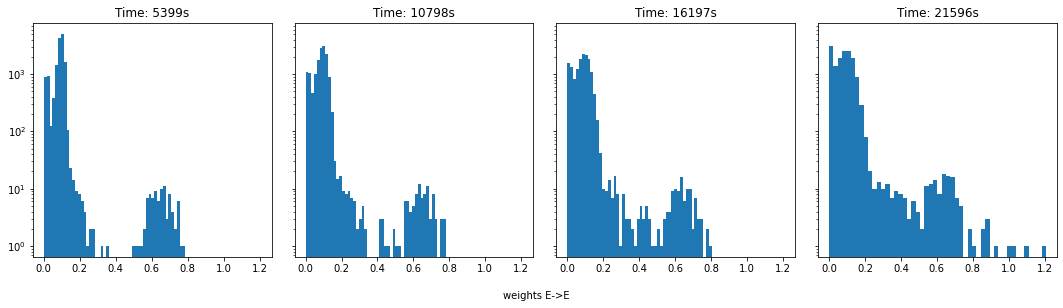

In [111]:
distribution_in_time(see,"E->E")

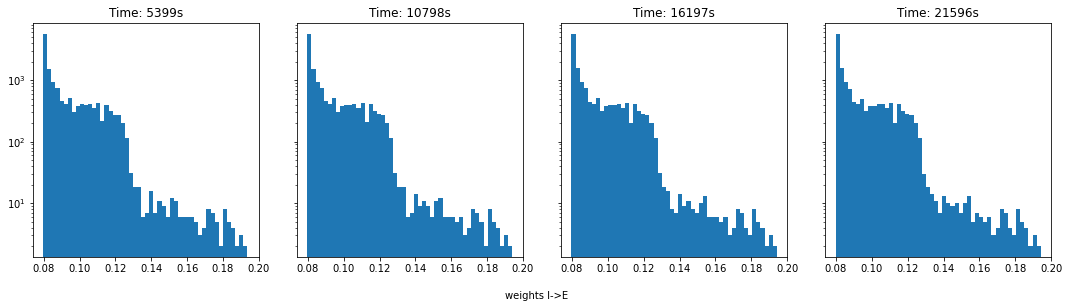

In [112]:
distribution_in_time(sie,"I->E")

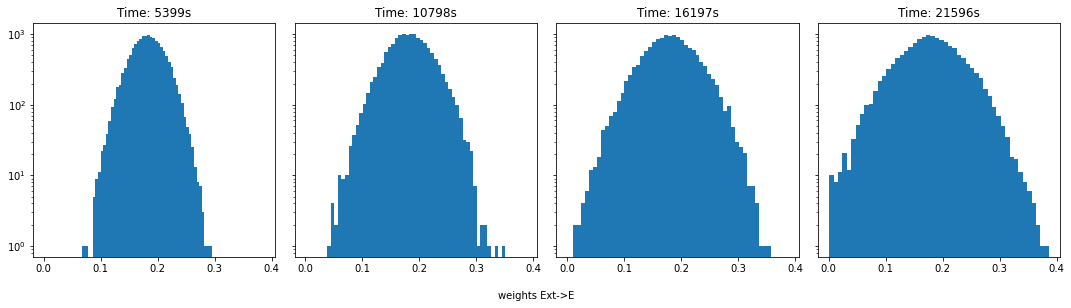

In [113]:
distribution_in_time(sse,"Ext->E")

### Rates and CV distribution over time

In [104]:
total_time = 21800
trange = 100
NE = 4096
numberof = 5
cvs_over_time = []
frequences_over_time = []
times_over_time = []

for t in range(int(total_time/numberof),total_time,int(total_time/numberof)):
    times, cells = np.array(sfo.get_spikes(t_start=t,t_stop=t+(trange/numberof))).T
    freqs = []
    cvs = []
    for i in range(NE):
        isi = np.diff(times[cells==i])
        isim = isi.mean()
        freqs.append(1/isim)
        cvs.append(isi.std()/isim)

    frequences_over_time.append(freqs)
    cvs_over_time.append(cvs)
    times_over_time.append(t)

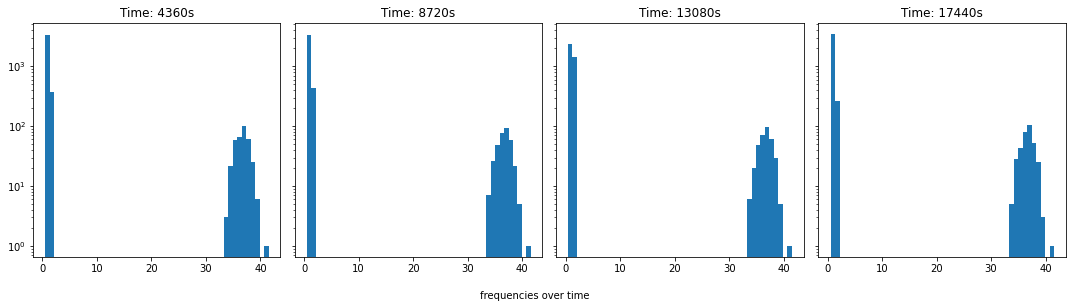

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=4,sharex=True,sharey=True,figsize=(15, 4))
cpt = 0
for freqs in range(len(frequences_over_time)):
        axes[cpt].hist(frequences_over_time[freqs],bins=50,log=True)
        #plt.hist(weight_InputE["w"][:,t],alpha=0.7,bins=15)
        axes[cpt].set_title("Time: "+str(times_over_time[freqs])+"s")
        cpt+=1
fig.text(0.5, -0.05, "frequencies over time ", ha='center')
fig.tight_layout()

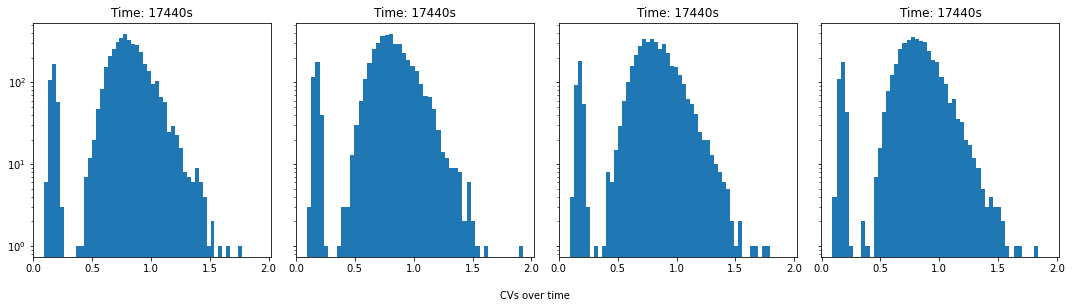

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=4,sharex=True,sharey=True,figsize=(15, 4))
cpt = 0
for cvs in range(len(cvs_over_time)):
        axes[cpt].hist(cvs_over_time[cvs],bins=50,log=True)
        #plt.hist(weight_InputE["w"][:,t],alpha=0.7,bins=15)
        axes[cpt].set_title("Time: "+str(times_over_time[freqs])+"s")
        cpt+=1
fig.text(0.5, -0.05, "CVs over time ", ha='center')
fig.tight_layout()

### Excitatory connexions are very strong between hyperactives neurones 

In [118]:
freqs= frequences_over_time[-1]

In [119]:
winner = np.where(np.array(freqs)>12)[0]

In [120]:
inside_weight = []
for n in winner:
    for n2 in winner :
        if n!= n2 :
            poid = w[n,n2]
            if poid> 0.0:
                inside_weight.append(w[n,n2])

#### Mean weight of excitatory connexions between hyperactives neurones very high compared to mean weights of all neurones

In [125]:
print("Mean weight of "+str(np.mean(inside_weight))+" for hyperactives neurons vs "+str(np.mean(w.data))+" for all neurons")

Mean weight of 0.6455190893859649 for hyperactives neurons vs 0.08575053768746127 for all neurons


### We can then analyse inhibitory connexions going into those hyperactives neurones

In [131]:
inside_inhweight = []
for n in range(int(NE/4)):
    for n2 in winner :
        if n!= n2 :
            poid = wie[n,n2]
            if poid> 0.0:
                inside_inhweight.append(wie[n,n2])

### Weight difference is not marked for synapse linking inhibition to excitatory neurones
### Compared to mean weight

In [135]:
print("Mean inhibitory weight of "+str(np.mean(inside_inhweight))+" for hyperactives neurons vs "+str(np.mean(wie.data))+" for all neurons")

Mean inhibitory weight of 0.10314464841654682 for hyperactives neurons vs 0.0923931901776419 for all neurons
